Train/Test sizes: (455, 30) (114, 30)
============================================================ LogisticRegression
============================================================ SVM_RBF
============================================================ KNN
CSV 已保存: d:\LiXinhui\Machine learning WJM\作业1\results\initial_model_metrics.csv
图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\roc_initial.png


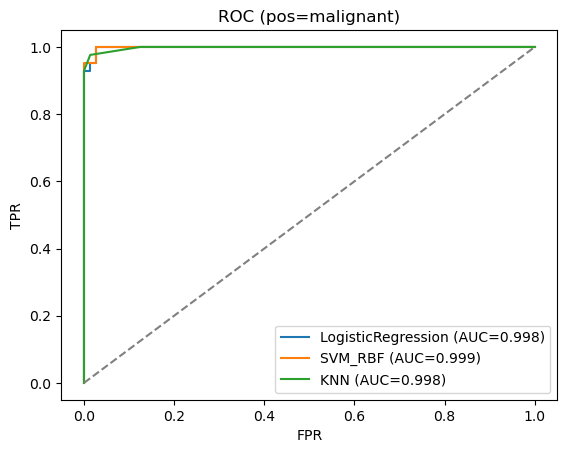

图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\cm_LogisticRegression.png


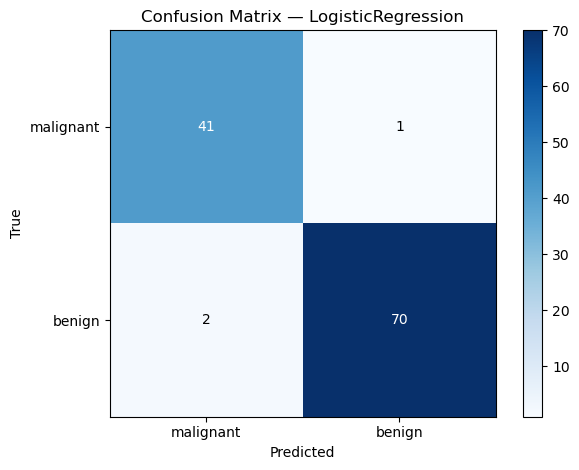

图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\cm_SVM_RBF.png


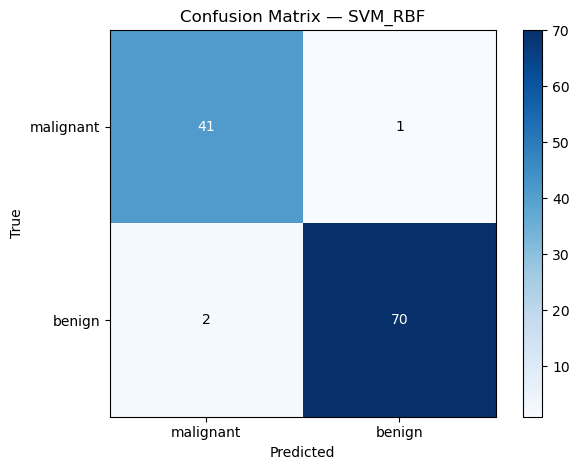

图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\cm_KNN.png


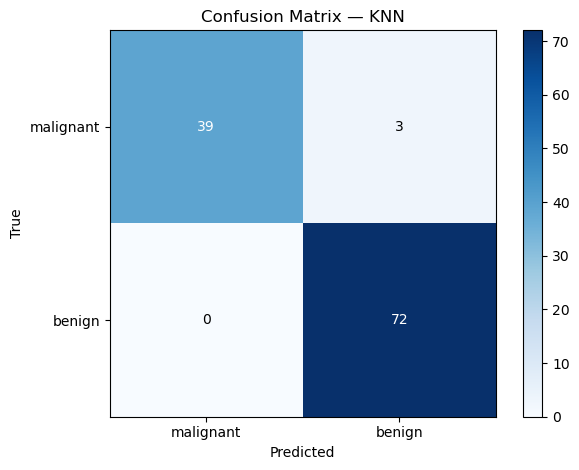


 各模型指标表已保存为: initial_model_metrics.csv
LogisticRegression: mean=0.9916 ± 0.0099
SVM_RBF: mean=0.9935 ± 0.0067
KNN: mean=0.9818 ± 0.0094
图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\cv_auc_violin.png


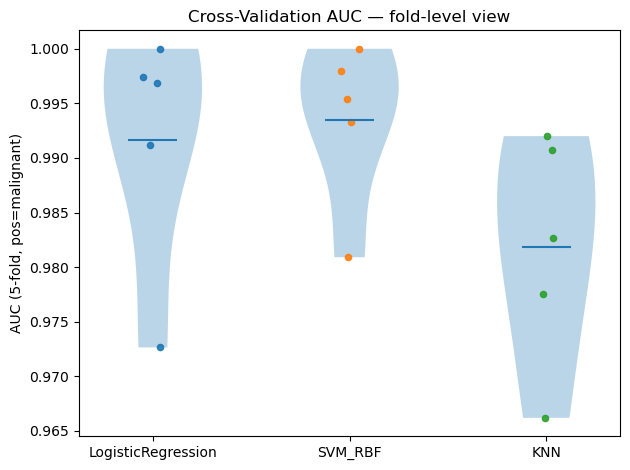

CSV 已保存: d:\LiXinhui\Machine learning WJM\作业1\results\fold_auc_5fold.csv
CSV 已保存: d:\LiXinhui\Machine learning WJM\作业1\results\threshold_metrics.csv
图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\threshold_tuning.png


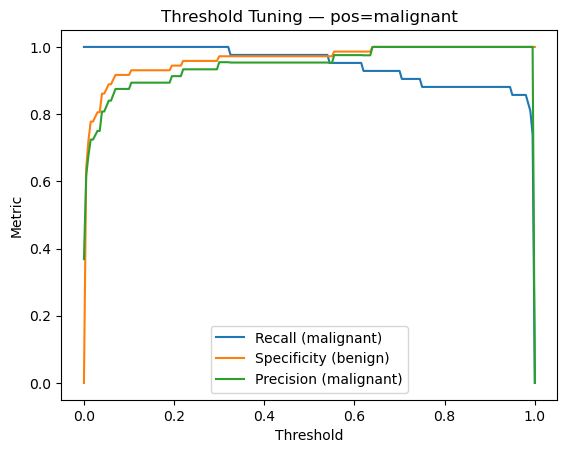

图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\pca_error_distribution.png


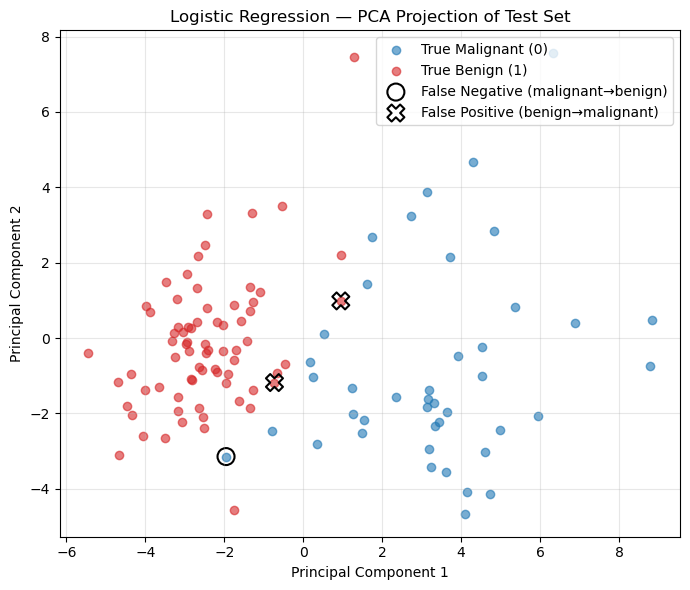


所有结果与图像已保存至: d:\LiXinhui\Machine learning WJM\作业1\results


In [10]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# ------------------------------------------------------------
# 0️ 环境与目录准备
# ------------------------------------------------------------
RANDOM_STATE = 8
TARGET_POSITIVE = 0
%matplotlib inline

save_dir = os.path.join(os.getcwd(), "results")
os.makedirs(save_dir, exist_ok=True)

def savefig(name, dpi=300):
    """保存当前图像到 results 文件夹"""
    path = os.path.join(save_dir, f"{name}.png")
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"图已保存: {path}")

def savecsv(df, name):
    """保存 DataFrame 到 results 文件夹"""
    path = os.path.join(save_dir, f"{name}.csv")
    df.to_csv(path, index=False)
    print(f"CSV 已保存: {path}")

# ------------------------------------------------------------
# 1️ 数据加载与划分
# ------------------------------------------------------------
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print('Train/Test sizes:', X_train.shape, X_test.shape)


# ------------------------------------------------------------
# 2️ 模型构建 & 绘图函数
# ------------------------------------------------------------
def build_models():
    return {
        "LogisticRegression": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ]),
        "SVM_RBF": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(probability=True, random_state=RANDOM_STATE))
        ]),
        "KNN": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier())
        ]),
    }

def plot_roc_curves(results, title="ROC (pos=malignant)"):
    plt.figure()
    for name, r in results.items():
        fpr, tpr, _ = r["roc"]
        plt.plot(fpr, tpr, label=f"{name} (AUC={r['auc']:.3f})")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title); plt.legend()
    savefig("roc_initial")
    plt.show()

def plot_confusion_matrix(cm, title="Confusion Matrix", cmap='Blues', labels=("malignant","benign"), name=None):
    plt.figure()
    plt.imshow(cm, cmap=cmap, interpolation="nearest")
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels); plt.yticks(ticks, labels)
    thr = cm.max()/2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center",
                     color="white" if cm[i,j]>thr else "black")
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout()
    if name:
        savefig(name)
    plt.show()

# ------------------------------------------------------------
# 3️ 基础模型评估
# ------------------------------------------------------------
models = build_models()
results = {}

for name, pipe in models.items():
    print("="*60, name)
    pipe.fit(X_train, y_train)
    pos_idx = list(pipe.classes_).index(0)
    y_score = pipe.predict_proba(X_test)[:, pos_idx]
    y_pred  = np.where(y_score >= 0.5, 0, 1)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    spec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)  
    f1   = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    auc  = roc_auc_score((y_test==0).astype(int), y_score)

    fpr, tpr, thr = roc_curve((y_test==0).astype(int), y_score, pos_label=1)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])

    metrics = {
        "Accuracy": acc,
        "Precision (malignant)": prec,
        "Recall/Sensitivity (malignant)": rec,
        "Specificity (benign)": spec,
        "F1-score (malignant)": f1,
        "ROC-AUC": auc
    }

    results[name] = {"metrics": metrics, "roc": (fpr,tpr,thr), "cm": cm}


df_metrics = pd.DataFrame({name: r["metrics"] for name, r in results.items()}).T
savecsv(df_metrics.reset_index().rename(columns={"index": "Model"}), "initial_model_metrics")

plot_roc_curves({n: {"roc": r["roc"], "auc": r["metrics"]["ROC-AUC"]} for n, r in results.items()})
for name, r in results.items():
    plot_confusion_matrix(r["cm"], title=f"Confusion Matrix — {name}", name=f"cm_{name}")

print("\n 各模型指标表已保存为: initial_model_metrics.csv")

# ------------------------------------------------------------
# 4️ 交叉验证 + 小提琴图
# ------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_bin = (y_train == 0).astype(int)
fold_scores, order = {}, []
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_bin, scoring="roc_auc", cv=cv, n_jobs=-1)
    fold_scores[name] = scores
    order.append(name)
    print(f"{name}: mean={scores.mean():.4f} ± {scores.std():.4f}")

plt.figure()
data_plot = [fold_scores[name] for name in order]
vp = plt.violinplot(data_plot, showmeans=True, showextrema=False, showmedians=False)
for i, name in enumerate(order, start=1):
    x = np.random.normal(i, 0.03, size=len(fold_scores[name]))
    plt.scatter(x, fold_scores[name], s=20, alpha=0.9)
plt.xticks(range(1, len(order)+1), order)
plt.ylabel("AUC (5-fold, pos=malignant)")
plt.title("Cross-Validation AUC — fold-level view")
plt.tight_layout()
savefig("cv_auc_violin")
plt.show()
savecsv(pd.DataFrame(fold_scores), "fold_auc_5fold")

# ------------------------------------------------------------
# 5️ 阈值扫描
# ------------------------------------------------------------
model_for_threshold = build_models()["LogisticRegression"]
model_for_threshold.fit(X_train, y_train)
pos_idx = list(model_for_threshold.classes_).index(0)
y_score = model_for_threshold.predict_proba(X_test)[:, pos_idx]

ts = np.linspace(0,1,201)
rec, spec, prec = [], [], []
for th in ts:
    y_pred = np.where(y_score >= th, 0, 1)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    tp, fn, tn, fp = cm[0,0], cm[0,1], cm[1,1], cm[1,0]
    rec.append(tp / (tp + fn + 1e-12))
    spec.append(tn / (tn + fp + 1e-12))
    prec.append(tp / (tp + fp + 1e-12))

df_threshold = pd.DataFrame({
    "Threshold": ts,
    "Recall_malignant": rec,
    "Specificity_benign": spec,
    "Precision_malignant": prec
})
savecsv(df_threshold, "threshold_metrics")

plt.figure()
plt.plot(ts, rec, label="Recall (malignant)")
plt.plot(ts, spec, label="Specificity (benign)")
plt.plot(ts, prec, label="Precision (malignant)")
plt.xlabel("Threshold"); plt.ylabel("Metric")
plt.title("Threshold Tuning — pos=malignant")
plt.legend()
savefig("threshold_tuning")
plt.show()

# ------------------------------------------------------------
# 6 模型何时出错（PCA）
# ------------------------------------------------------------
model = build_models()["LogisticRegression"]
model.fit(X_train, y_train)
pos_idx = list(model.classes_).index(0)
y_score = model.predict_proba(X_test)[:, pos_idx]
y_pred  = np.where(y_score >= 0.5, 0, 1)

scaler_vis = StandardScaler().fit(X_train)
X_train_std = scaler_vis.transform(X_train)
X_test_std  = scaler_vis.transform(X_test)

pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit(X_train_std).transform(X_test_std)

y_test_np = np.asarray(y_test)
mask_fn = (y_test_np == 0) & (y_pred == 1)
mask_fp = (y_test_np == 1) & (y_pred == 0)

plt.figure(figsize=(7,6))
plt.scatter(X_test_pca[y_test_np==0,0], X_test_pca[y_test_np==0,1],
            c="tab:blue", alpha=0.6, label="True Malignant (0)")
plt.scatter(X_test_pca[y_test_np==1,0], X_test_pca[y_test_np==1,1],
            c="tab:red", alpha=0.6, label="True Benign (1)")
plt.scatter(X_test_pca[mask_fn,0], X_test_pca[mask_fn,1],
            edgecolor="black", facecolor="none", s=150, linewidth=1.5,
            label="False Negative (malignant→benign)")
plt.scatter(X_test_pca[mask_fp,0], X_test_pca[mask_fp,1],
            marker="X", edgecolor="black", facecolor="none", s=150, linewidth=1.5,
            label="False Positive (benign→malignant)")
plt.title("Logistic Regression — PCA Projection of Test Set")
plt.xlabel("Principal Component 1"); plt.ylabel("Principal Component 2")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
savefig("pca_error_distribution")
plt.show()

print("\n所有结果与图像已保存至:", save_dir)


Grid search for: LogisticRegression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV AUC: 0.9932920536635708
Grid search for: SVM_RBF
Best params: {'clf__C': 3.0, 'clf__gamma': 'scale'}
Best CV AUC: 0.9947368421052631
Grid search for: KNN
Best params: {'clf__n_neighbors': 9, 'clf__weights': 'distance'}
Best CV AUC: 0.9889576883384935
---------------------------------------------------------------------- LogisticRegression (tuned)
Accuracy                          0.982456
Precision (malignant)             0.976190
Recall/Sensitivity (malignant)    0.976190
Specificity (benign)              0.986111
F1-score (malignant)              0.976190
ROC-AUC                           0.997685
---------------------------------------------------------------------- SVM_RBF (tuned)
Accuracy                          0.982456
Precision (malignant)             0.976190
Recall/Sensitivity (malignant)    0.976190
Specificity (benign)              0.986111
F1-score (malig

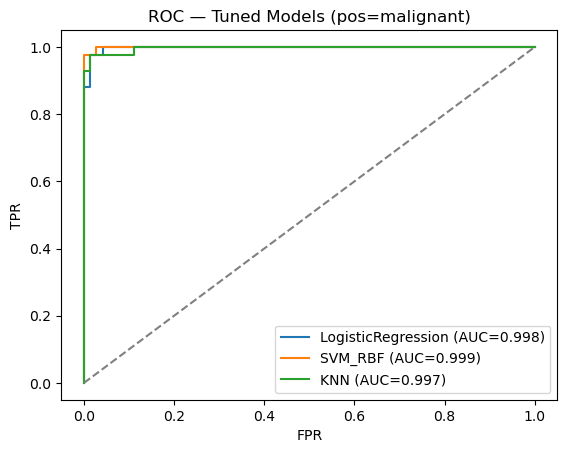

图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\cm_tuned_LogisticRegression.png


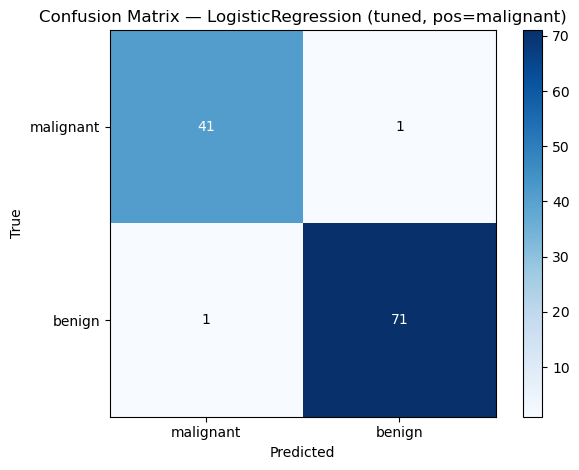

图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\cm_tuned_SVM_RBF.png


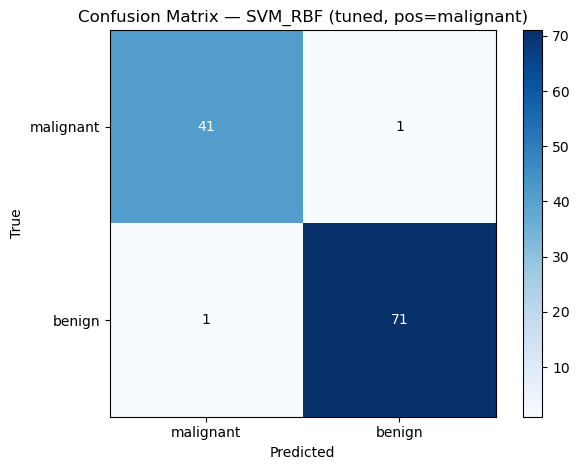

图已保存: d:\LiXinhui\Machine learning WJM\作业1\results\cm_tuned_KNN.png


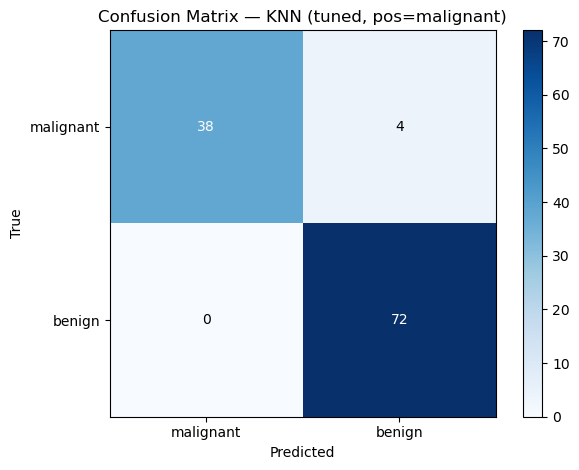


 调参后模型评估完成，结果文件:
  - tuned_model_metrics.csv
  - roc_tuned_models.png
  - cm_tuned_*.png 已全部保存


In [11]:
# ------------------------------------------------------------
# 超参数调优 + 多指标评估 + 自动保存
# ------------------------------------------------------------
param_grids = {
    "LogisticRegression": {"clf__C":[0.1,1.0,3.0,10.0], "clf__penalty":["l2"], "clf__solver":["lbfgs"]},
    "SVM_RBF": {"clf__C":[0.5,1.0,3.0,10.0], "clf__gamma":["scale",0.1,0.01]},
    "KNN": {"clf__n_neighbors":[3,5,7,9,11], "clf__weights":["uniform","distance"]},
}

def eval_on_test(pipe, X_train, y_train, X_test, y_test, name=""):
    """统一测试评估函数"""
    pipe.fit(X_train, y_train)
    pos_idx = list(pipe.classes_).index(0)
    y_score = pipe.predict_proba(X_test)[:, pos_idx]
    y_pred  = np.where(y_score >= 0.5, 0, 1)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (malignant)": precision_score(y_test, y_pred, pos_label=0, zero_division=0),
        "Recall/Sensitivity (malignant)": recall_score(y_test, y_pred, pos_label=0, zero_division=0),
        "Specificity (benign)": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1-score (malignant)": f1_score(y_test, y_pred, pos_label=0, zero_division=0),
        "ROC-AUC": roc_auc_score((y_test==0).astype(int), y_score),
    }

    fpr, tpr, thr = roc_curve((y_test==0).astype(int), y_score, pos_label=1)
    return {"metrics": metrics, "roc": (fpr,tpr,thr), "cm": cm}

# === Grid Search ===
best_models = {}
y_train_bin = (y_train == 0).astype(int)
for name, base in build_models().items():
    print("="*70)
    print("Grid search for:", name)
    gs = GridSearchCV(base, param_grids[name], scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    gs.fit(X_train, y_train_bin)
    print("Best params:", gs.best_params_)
    print("Best CV AUC:", gs.best_score_)
    best_models[name] = gs.best_estimator_

# === 测试集评估 ===
tuned_results = {}
for name, pipe in best_models.items():
    print("-"*70, name, "(tuned)")
    r = eval_on_test(pipe, X_train, y_train, X_test, y_test, name)
    tuned_results[name] = r
    print(pd.Series(r["metrics"]).to_string())

# === 保存多指标 CSV ===
df_tuned = pd.DataFrame({name: r["metrics"] for name, r in tuned_results.items()}).T
savecsv(df_tuned.reset_index().rename(columns={"index": "Model"}), "tuned_model_metrics")

# === 绘制 ROC 曲线 ===
plt.figure()
for name, r in tuned_results.items():
    fpr, tpr, _ = r["roc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC={r['metrics']['ROC-AUC']:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC — Tuned Models (pos=malignant)")
plt.legend()
savefig("roc_tuned_models")
plt.show()

# === 绘制 Confusion Matrix ===
for name, r in tuned_results.items():
    plot_confusion_matrix(r["cm"], title=f"Confusion Matrix — {name} (tuned, pos=malignant)",
                          name=f"cm_tuned_{name}")

print("\n 调参后模型评估完成，结果文件:")
print("  - tuned_model_metrics.csv")
print("  - roc_tuned_models.png")
print("  - cm_tuned_*.png 已全部保存")
